In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

## Load in Data

In [2]:
# load in training and testing data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

#labels = train_data['RainToday']
#train_data = train_data.drop(['RainToday'], axis=1)

In [3]:
train_data

,Date,Location,MinTemp,MaxTemp,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM
0,2016-07-19,NaN,19.5,NaN,5.69496,0.500000,ENE,61.0,ENE,ENE,...,86.641375,41.810006,1020.4,1021.9,NaN,7.00000,NaN,19.6,0,NaN
1,2010-07-26,Canberra,2.1,15.7,NaN,5.700000,E,26.0,NaN,SE,...,53.275715,76.598048,1023.7,1020.8,4.000000,1.00000,9.0,14.1,0,0.0
2,2014-04-02,Woomera,20.9,36.1,5.69496,NaN,S,39.0,S,SW,...,15.471574,52.163254,1017.1,1014.9,4.167266,4.27812,24.2,33.9,0,0.0
3,2014-11-19,Tuggeranong,11.5,23.9,5.69496,7.993227,NNE,35.0,W,NaN,...,46.442398,67.664733,1010.2,NaN,4.167266,4.27812,13.8,21.8,1,0.2
4,NaN,Hobart,8.2,20.5,3.20000,NaN,N,69.0,N,WNW,...,51.830889,51.770240,NaN,1001.2,7.000000,7.00000,NaN,17.6,0,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35151,2016-11-10,NaN,21.4,29.5,6.60000,12.100000,E,28.0,E,NE,...,53.740315,56.027329,1018.1,NaN,3.000000,2.00000,26.9,NaN,0,NaN
35152,2014-08-08,Wollongong,16.4,20.0,5.69496,NaN,NE,46.0,NE,NE,...,81.517289,50.510598,1029.3,1024.0,NaN,1.00000,17.7,18.5,0,0.0
35153,2009-12-07,Tuggeranong,8.7,29.7,5.69496,7.993227,ENE,33.0,NaN,NNW,...,25.812760,64.041921,NaN,1014.6,4.167266,4.27812,15.4,NaN,0,0.0
35154,2012-10-18,Ballarat,10.2,18.7,5.69496,7.993227,SE,63.0,ESE,SE,...,52.608538,NaN,1026.6,1024.9,6.000000,4.27812,12.2,17.4,0,NaN


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35156 entries, 0 to 35155
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           28098 non-null  object 
 1   Location       27922 non-null  object 
 2   MinTemp        28089 non-null  float64
 3   MaxTemp        28264 non-null  float64
 4   Evaporation    28142 non-null  float64
 5   Sunshine       28093 non-null  float64
 6   WindGustDir    26466 non-null  object 
 7   WindGustSpeed  28148 non-null  float64
 8   WindDir9am     26132 non-null  object 
 9   WindDir3pm     27424 non-null  object 
 10  WindSpeed9am   28120 non-null  float64
 11  WindSpeed3pm   28143 non-null  float64
 12  Humidity9am    28128 non-null  float64
 13  Humidity3pm    28064 non-null  float64
 14  Pressure9am    28118 non-null  float64
 15  Pressure3pm    28060 non-null  float64
 16  Cloud9am       28127 non-null  float64
 17  Cloud3pm       28208 non-null  float64
 18  Temp9a

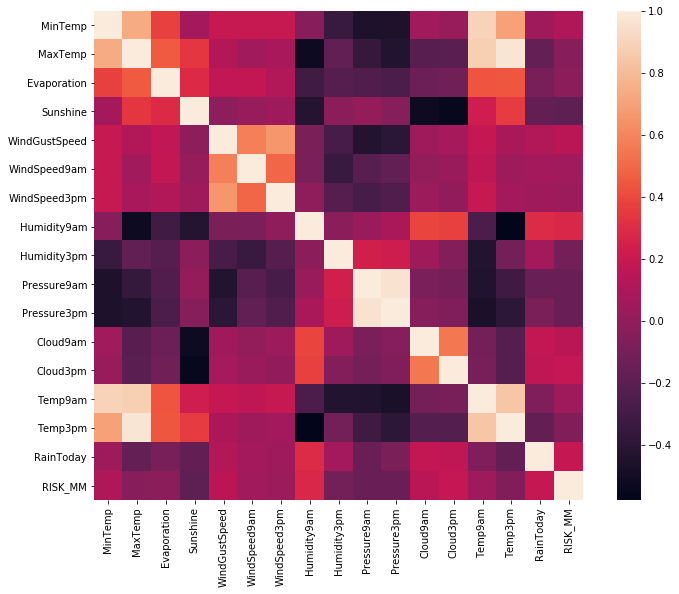

In [5]:
import seaborn as sns
correlation_matrix = train_data.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix, square = True)
plt.show()

## One Hot Encoding

In [6]:
# split date into year, month, and day
def split_date(data):
    years = []
    months = []
    days = []
    for x in data['Date']:
        if not pd.isnull(x):
            date = x.split('-')
            years.append(date[0])
            months.append(date[1])
            days.append(date[2])
        else:
            years.append(np.nan)
            months.append(np.nan)
            days.append(np.nan)
    
    output = pd.DataFrame(zip(years, months, days), columns=['Year','Month','Day'])
    
    return output

train_date = split_date(train_data)
test_date = split_date(test_data)

train_data = pd.concat([train_data,train_date], axis=1)
test_data = pd.concat([test_data,test_date], axis=1)

In [7]:
def one_hot_encoding(data, feature, num_count):
    data_feature = pd.DataFrame(data[feature])
    data_feature.fillna('Unknown', inplace=True)

    onehotencoder = OneHotEncoder()
    data_ohe = onehotencoder.fit_transform(data_feature).toarray()
    col_name = [str(num_count)+'_'+x[3:] for x in onehotencoder.get_feature_names()]
    output = pd.DataFrame(data_ohe, columns=col_name)
    output = output.drop([str(num_count)+'_'+'Unknown'], axis=1)
    
    return output

In [8]:
train_year = one_hot_encoding(train_data, 'Year', 1)
test_year = one_hot_encoding(test_data, 'Year', 1)
train_month = one_hot_encoding(train_data, 'Month', 2)
test_month = one_hot_encoding(test_data, 'Month', 2)
train_day = one_hot_encoding(train_data, 'Day', 3)
test_day = one_hot_encoding(test_data, 'Day', 3)
train_locats = one_hot_encoding(train_data, 'Location', 4)
test_locats = one_hot_encoding(test_data, 'Location', 4)
train_wind_dir = one_hot_encoding(train_data, 'WindGustDir', 5)
test_wind_dir = one_hot_encoding(test_data, 'WindGustDir', 5)
train_wind_9am = one_hot_encoding(train_data, 'WindDir9am', 6)
test_wind_9am = one_hot_encoding(test_data, 'WindDir9am', 6)
train_wind_3pm = one_hot_encoding(train_data, 'WindDir3pm', 7)
test_wind_3pm = one_hot_encoding(test_data, 'WindDir3pm', 7)

train_data = pd.concat([train_data,train_year,train_month,train_day,train_locats,train_wind_dir,train_wind_9am,train_wind_3pm], axis=1)
test_data = pd.concat([test_data,test_year,test_month,test_day,test_locats,test_wind_dir,test_wind_9am,test_wind_3pm], axis=1)

In [9]:
train_data

,Date,Location,MinTemp,MaxTemp,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,7_NNW,7_NW,7_S,7_SE,7_SSE,7_SSW,7_SW,7_W,7_WNW,7_WSW
0,2016-07-19,NaN,19.5,NaN,5.69496,0.500000,ENE,61.0,ENE,ENE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-07-26,Canberra,2.1,15.7,NaN,5.700000,E,26.0,NaN,SE,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014-04-02,Woomera,20.9,36.1,5.69496,NaN,S,39.0,S,SW,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2014-11-19,Tuggeranong,11.5,23.9,5.69496,7.993227,NNE,35.0,W,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,Hobart,8.2,20.5,3.20000,NaN,N,69.0,N,WNW,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35151,2016-11-10,NaN,21.4,29.5,6.60000,12.100000,E,28.0,E,NE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35152,2014-08-08,Wollongong,16.4,20.0,5.69496,NaN,NE,46.0,NE,NE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35153,2009-12-07,Tuggeranong,8.7,29.7,5.69496,7.993227,ENE,33.0,NaN,NNW,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35154,2012-10-18,Ballarat,10.2,18.7,5.69496,7.993227,SE,63.0,ESE,SE,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Preprocessing

In [10]:
# non-numerical features
train_data = train_data.drop([col for col in train_data.columns if train_data[col].dtype == np.object], axis=1)
test_data = test_data.drop([col for col in test_data.columns if test_data[col].dtype == np.object], axis=1)

In [11]:
# missing values
def fill_missing_value(data):
    imr = SimpleImputer(missing_values=np.nan, strategy='mean')
    imr = imr.fit(data.values)
    imputed_data = imr.transform(data.values)

    df_impute = pd.DataFrame(imputed_data)
    df_impute.columns = data.columns
    
    return df_impute

train_data = fill_missing_value(train_data)
test_data = fill_missing_value(test_data)

train_data

,MinTemp,MaxTemp,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,7_NNW,7_NW,7_S,7_SE,7_SSE,7_SSW,7_SW,7_W,7_WNW,7_WSW
0,19.5,23.727411,5.694960,0.500000,61.0,31.000000,22.000000,86.641375,41.810006,1020.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.1,15.700000,5.704239,5.700000,26.0,9.000000,7.000000,53.275715,76.598048,1023.700000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20.9,36.100000,5.694960,7.997373,39.0,31.000000,17.000000,15.471574,52.163254,1017.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,11.5,23.900000,5.694960,7.993227,35.0,7.000000,17.000000,46.442398,67.664733,1010.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.2,20.500000,3.200000,7.997373,69.0,13.799491,18.430319,51.830889,51.770240,1018.033092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35151,21.4,29.500000,6.600000,12.100000,28.0,13.799491,15.000000,53.740315,56.027329,1018.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35152,16.4,20.000000,5.694960,7.997373,46.0,7.000000,35.000000,81.517289,50.510598,1029.300000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35153,8.7,29.700000,5.694960,7.993227,33.0,0.000000,9.000000,25.812760,64.041921,1018.033092,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35154,10.2,18.700000,5.694960,7.993227,63.0,31.000000,18.430319,52.608538,60.238943,1026.600000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Training Models
### Random Oversampling + XGBoost

In [12]:
labels = train_data['RainToday']
train_data = train_data.drop(['RainToday'], axis=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train_data, labels, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print(X_train.shape)
#print(X_val.shape)
print(X_test.shape)

(28124, 167)
(7032, 167)


In [14]:
# Class count
X_train['RainToday'] = y_train
df_train = X_train
count_class_0, count_class_1 = df_train['RainToday'].value_counts()

# Divide by class
df_class_0 = df_train[df_train['RainToday'] == 0]
df_class_1 = df_train[df_train['RainToday'] == 1]

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over['RainToday'].value_counts())

X_train = df_test_over

y_train = X_train['RainToday']
X_train = X_train.drop(['RainToday'], axis=1)

print(X_train.shape)
print(y_train.shape)
X_train

Random over-sampling:
1.0    25136
0.0    25136
Name: RainToday, dtype: int64
(50272, 167)
(50272,)


/home/ginger/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MinTemp,MaxTemp,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,7_NNW,7_NW,7_S,7_SE,7_SSE,7_SSW,7_SW,7_W,7_WNW,7_WSW
2908,9.300000,30.800000,5.704239,7.993227,39.424649,13.799491,4.000000,25.220023,60.238943,1012.10000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
31573,20.800000,29.400000,5.694960,7.997373,48.000000,4.000000,18.430319,72.915297,72.730534,1020.20000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4135,12.102032,23.727411,5.694960,7.993227,31.000000,9.000000,6.000000,47.360219,60.238943,1009.50000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13461,12.102032,29.200000,9.000000,12.600000,54.000000,9.000000,39.000000,51.871237,55.998098,1014.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26627,6.700000,23.727411,5.704239,7.993227,39.383150,13.799491,9.000000,36.684161,60.238943,1018.03427,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22958,10.800000,23.727411,4.800000,7.997373,74.000000,13.799491,28.000000,85.510598,41.010675,1003.30000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7372,5.700000,23.727411,5.694960,7.997373,63.000000,28.000000,28.000000,55.960279,64.252089,1018.03427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31659,10.000000,20.000000,5.694960,7.997373,39.424649,26.000000,18.435879,54.865890,85.839453,1018.03427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33348,7.800000,16.100000,5.800000,4.000000,39.383150,39.000000,59.000000,74.244124,62.711486,1013.50000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
from xgboost import XGBClassifier

eta = [0.1, 0.2, 0.3]
min_child_weight = [2, 3, 4]
max_depth = [10, 11, 12]
gamma = [0.1, 0.2, 0.3]
subsample = [0.5, 0.6, 0.7]
colsample_bytree = [0.2, 0.3, 0.4]

best_score = 0

for e in eta:
    for mcw in min_child_weight:
        for md in max_depth:
            for g in gamma:
                for s in subsample:
                    for cb in colsample_bytree:
                        model = XGBClassifier(random_state=0, eta=e, min_child_weight=mcw, max_depth=md, gamma=g, subsample=s,
                                             colsample_bytree=cb)
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)
                        score = f1_score(y_test, y_pred)
                        if score > best_score:
                            best_score = score
                            best_parameters = {'eta':e, 'min_child_weight':mcw, 'max_depth':md, 'gamma':g, 
                                               'subsample':s, 'colsample_bytree':cb}
                            print('parameters:', best_parameters, 'score:', best_score)
                            
model = XGBClassifier(**best_parameters)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_score = f1_score(y_test, y_pred)
print("Best score on test set: {:.4f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

parameters: {'eta': 0.1, 'min_child_weight': 2, 'max_depth': 10, 'gamma': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.2} score: 0.43667196608373077
parameters: {'eta': 0.1, 'min_child_weight': 2, 'max_depth': 10, 'gamma': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.3} score: 0.43675675675675674
parameters: {'eta': 0.1, 'min_child_weight': 2, 'max_depth': 10, 'gamma': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.4} score: 0.4424581005586592
parameters: {'eta': 0.1, 'min_child_weight': 2, 'max_depth': 10, 'gamma': 0.3, 'subsample': 0.6, 'colsample_bytree': 0.2} score: 0.4431137724550898
parameters: {'eta': 0.1, 'min_child_weight': 2, 'max_depth': 12, 'gamma': 0.3, 'subsample': 0.5, 'colsample_bytree': 0.3} score: 0.4470443349753695
parameters: {'eta': 0.1, 'min_child_weight': 3, 'max_depth': 10, 'gamma': 0.2, 'subsample': 0.6, 'colsample_bytree': 0.2} score: 0.4478723404255319
parameters: {'eta': 0.2, 'min_child_weight': 4, 'max_depth': 11, 'gamma': 0.1, 'subsample': 0.7, 'colsample_by

In [16]:
model = XGBClassifier(random_state=0, colsample_bytree=0.3, eta=0.1, gamma=0.2, max_depth=11, min_child_weight=3, subsample=0.6)
model.fit(X_train, y_train)

# predict on training data
y_pred_decision = model.predict(X_train)
print('[training]')
print('Accuracy: %f' % accuracy_score(y_train, y_pred_decision))
print('f1-score: %f' % f1_score(y_train, y_pred_decision))
'''
# predict on validation data
y_pred_decision = model.predict(X_val)
print('[validation]')
print('Accuracy: %f' % accuracy_score(y_val, y_pred_decision))
print('f1-score: %f' % f1_score(y_val, y_pred_decision))
'''
# predict on test data
y_pred_decision = model.predict(X_test)
print('[testing]')
print('Accuracy: %f' % accuracy_score(y_test, y_pred_decision))
print('f1-score: %f' % f1_score(y_test, y_pred_decision))

[training]
Accuracy: 0.972271
f1-score: 0.972854
[testing]
Accuracy: 0.863055
f1-score: 0.430514


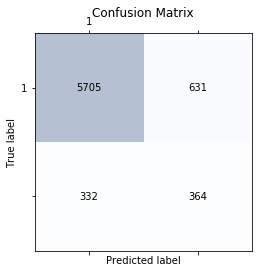

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_decision)
ax = plt.subplot()
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels([0, 1])
ax.yaxis.set_ticklabels([0, 1])
plt.show()

## Predict on Testing Data

In [18]:
ans_pred = model.predict(test_data)
df_sap = pd.DataFrame(ans_pred.astype(int), columns = ['RainToday'])
df_sap.to_csv('myAns.csv',  index_label = 'Id')